In [257]:
import torch
import torch.nn as nn
import numpy as np
import  matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from math import floor # Round numbers down to the nearest integer

In [258]:
 # Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

In [259]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

In [260]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [261]:
# Define the function to plot the sample data as images

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [262]:
# LOAD SOME DATA

IMAGE_SIZE = 16

# create a transform to resize the image and convert it to a tensor
composed = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

# Show the data type for each element in dataset
type(train_dataset[0][1])

int

9


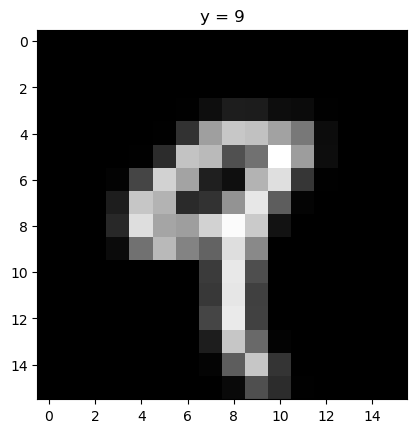

In [263]:
# the fifth  data element
print(train_dataset[4][1])

# its image
show_data(train_dataset[4])

In [264]:
# Build a Convolutional Network class with two Convolutional layers and one fully connected layer. 
# Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.

# CREATE THE MODEL
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * IMAGE_SIZE, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each steps
    def activations(self, x):
        #outputs activation
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        
        out = out.view(out.size(0),-1)        
        
        return z1, a1, z2, a2, out1, out

# Create the model object using CNN class

# There are 16 output channels for the first layer, and 32 output channel for the second layer
model = CNN(out_1=16, out_2=32)

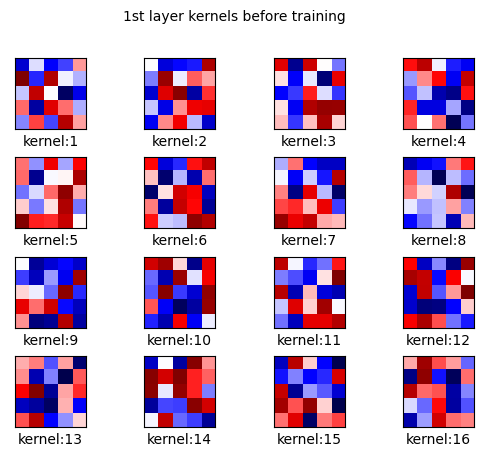

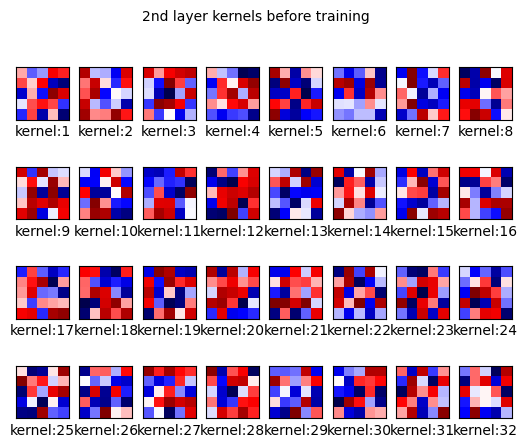

In [265]:
# plot the kernels before the initilization of the training

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [266]:
# LOSS CRITERION, DATALOADER, OPTIMIZER

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000) 

In [267]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs):
    
    #global variable 
    N_test=len(validation_dataset)
    
    accuracy_list=[]
    loss_list=[]
    
    for epoch in range(n_epochs):
        for x, y in train_loader:
                                    
            model.train()
            
            optimizer.zero_grad()
            
            z = model(x)
            
            loss = criterion(z, y)
            loss.backward()
            
            optimizer.step()
            
            loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
                        
            model.eval()
            
            z = model(x_test)
            
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

accuracy_list_normal, loss_list_normal=train_model(model=model,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

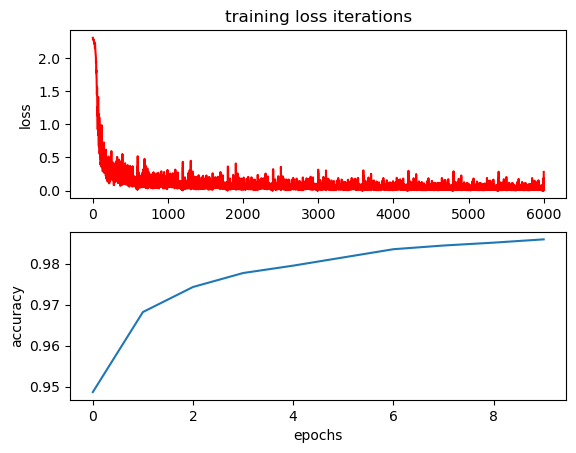

In [268]:
def plot_accuracy_loss(loss_list_normal, accuracy_list_normal): 
    plt.subplot(2, 1, 1)
    plt.plot(loss_list_normal, 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(accuracy_list_normal)
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()
    
plot_accuracy_loss(loss_list_normal, accuracy_list_normal)        

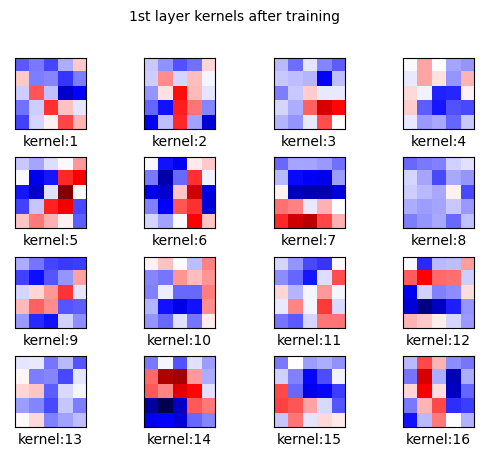

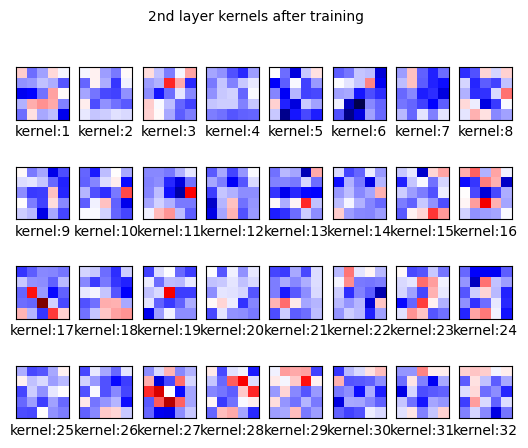

In [269]:
# replot the kernels (now that the model is trained)

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels after training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels after training' )

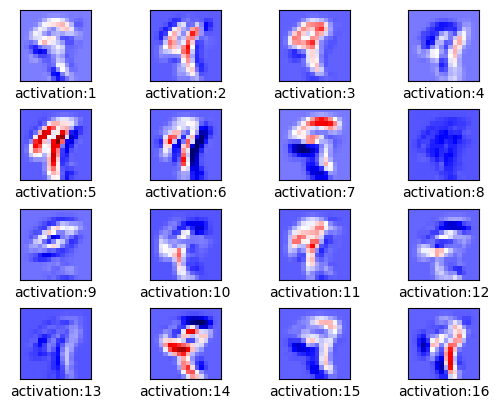

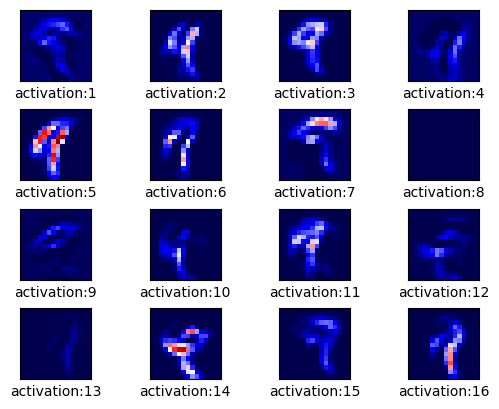

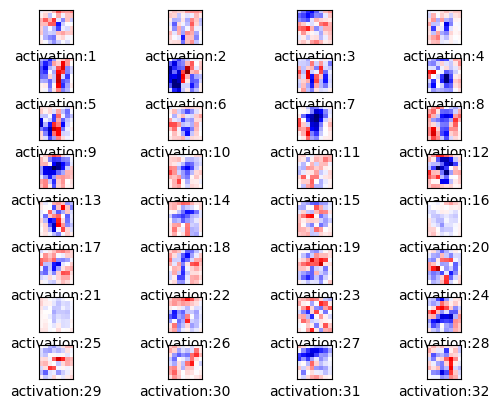

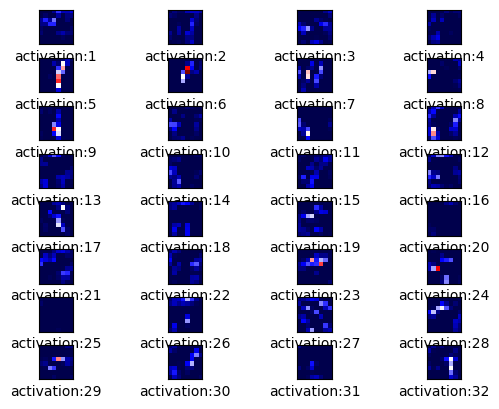

In [270]:
# Use the CNN class' activations method to see the steps for the fifth image
out = model.activations(train_dataset[4][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

# Plot the outputs after the first CNN
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")
# Plot the outputs after the first Relu
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

# Plot the outputs after the second CNN
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")
# Plot the outputs after the second Relu
plot_activations(out[3], number_rows=32 // 4, name="Output after the 2nd Relu")

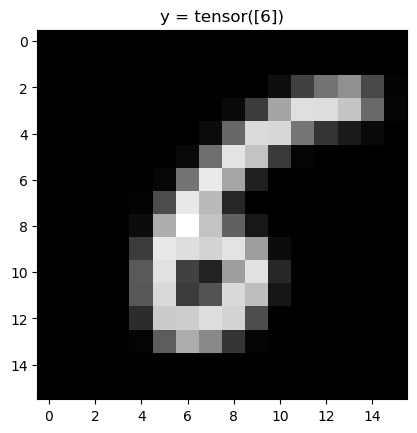

yhat: tensor([5])


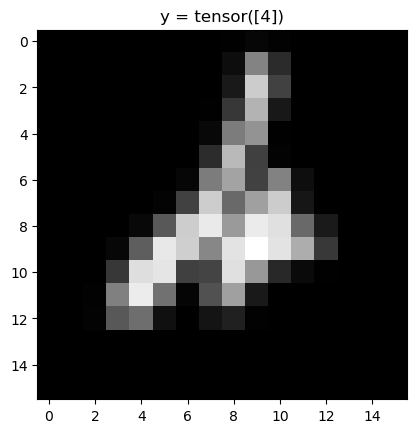

yhat: tensor([2])


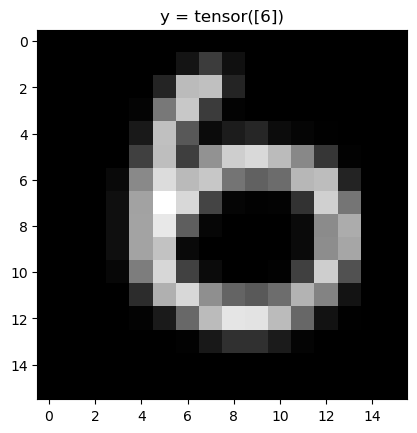

yhat: tensor([0])


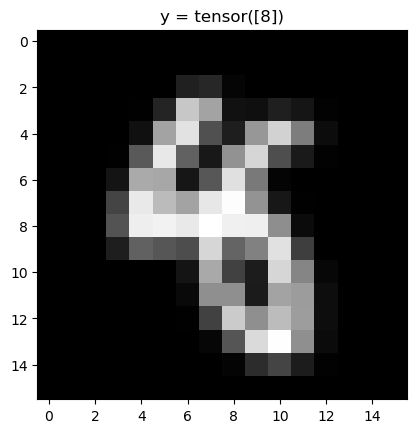

yhat: tensor([4])


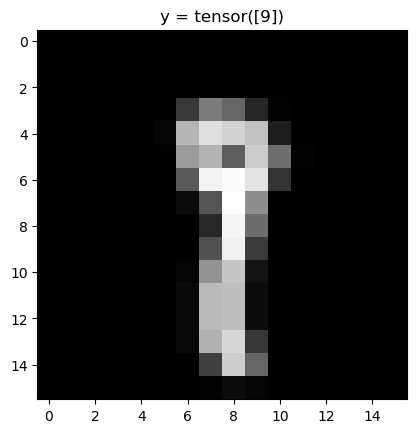

yhat: tensor([1])


In [271]:
# 5 first mis-classified samples:

my_validation_DataLoader =  DataLoader(dataset=validation_dataset, batch_size=1)

count = 0
for x, y in my_validation_DataLoader : # instead of validation_dataset
    z = model(x)
    _,yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)        
        count += 1
    if count >= 5:
        break

In [272]:
# PLAY A LITLLE MORE BY CREATING THE ABOVE CNN CLASS WITH BATCH NORMALIZATION

class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1) # batch norm to cnn1
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2) # batch norm to cnn2
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_2 * IMAGE_SIZE, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(number_of_classes) # batch norm to FLATTENED 
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)        
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x
    
model_batch=CNN_batch(out_1=16, out_2=32)    

In [273]:
# SAME LOSS CRITERION,  
# NEW OPTIMIZER FOR BATCH_NORM MODEL

optimizer_batch = torch.optim.SGD(model_batch.parameters(), lr = 0.1)

accuracy_list_batch, loss_list_batch=train_model(model=model_batch,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer_batch)

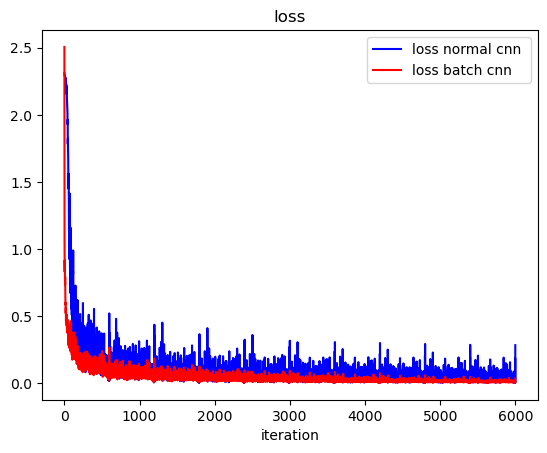

In [274]:
# Plot the loss

plt.plot(loss_list_normal, 'b',label='loss normal cnn ')
plt.plot(loss_list_batch,'r',label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

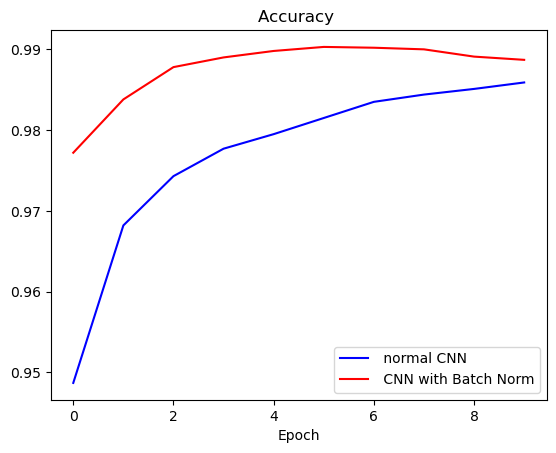

In [275]:
# Plot the accuracy

plt.plot(accuracy_list_normal, 'b',label=' normal CNN')
plt.plot(accuracy_list_batch,'r',label=' CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()